<a href="https://colab.research.google.com/github/rsa-umn/data-mining/blob/main/project-notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Group Project
## Group 16 - Ray, Colleen, Tanmay, Lydia

This notebook contains the predictive models used as part of our project to classify rice crop pests as a function of weather in India.

**Dataset source:** https://github.com/rsa-umn/data-mining/blob/main/RICE.csv
(If using Google Colab, this file needs to be manually loaded into the `/content` directory when the Colab instance is started or restarted). Otherwise it should be in the same directory as this Jupyter notebook.

In [2]:
#Initialization - library imports, CSV parsing
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_curve, RocCurveDisplay

df_pests = pd.read_csv('RICE.csv',encoding="utf-8")
df_pests

,year,std_week,pest_value,collect_type,max_temp,min_temp,humidity1,humidity2,rainfall,wind,sunshine,evp,pest_name,location
0,2003,1,0.0,Number/hill,27.9,14.8,94.7,51.3,0.0,3.1,8.7,2.7,Brownplanthopper,Cuttack
1,2003,2,0.0,Number/hill,27.2,15.0,93.9,53.1,0.0,2.1,8.7,2.4,Brownplanthopper,Cuttack
2,2003,3,0.0,Number/hill,28.7,18.3,94.1,56.7,0.6,4.8,6.7,2.8,Brownplanthopper,Cuttack
3,2003,4,0.0,Number/hill,25.3,16.4,90.9,57.4,0.3,6.5,5.3,3.0,Brownplanthopper,Cuttack
4,2003,5,0.0,Number/hill,28.8,18.7,95.7,55.0,0.0,5.2,6.3,2.8,Brownplanthopper,Cuttack
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19399,2011,48,31.0,Number/Light trap,30.2,17.2,78.1,41.6,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar
19400,2011,49,38.0,Number/Light trap,30.5,12.9,84.3,33.4,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar
19401,2011,50,6.0,Number/Light trap,30.2,14.2,83.4,49.6,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar
19402,2011,51,13.0,Number/Light trap,29.0,11.8,81.9,49.3,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar


# Data Exploration



**Unique Pests**
- 11 unique pests in the dataset.
- Yellow stem borer moth the most _measured_ (not necessarily the highest count)
- Neck blast fungus least measured.

**Time Periods**
- between 1959 - 2011
- early years have significantly less observations

**Locations**
- 6 regions surveyed in different parts of India
- Maruteru most surveyed (7053 records)
- Palampur least (1248 records)

In [ ]:

df_pests.pest_name.value_counts()
df_pests.year.value_counts().sort_index()
df_pests.location.value_counts()

,count
location,
Maruteru,7053
Rajendranagar,5539
Raipur,2132
Ludhiana,1976
Cuttack,1456
Palampur,1248


# Performance Measures

These functions will be used later to show different performance metrics for each model.

In [ ]:
# print performance measures
def print_performance_measures(y_true, y_pred):
  print(f"Accuracy is {accuracy_score(y_true, y_pred)}")
  print(f"Precision is {precision_score(y_true, y_pred, average="weighted")}")
  print(f"Recall is {recall_score(y_true, y_pred)}")
  print(f"F-measure is {f1_score(y_true, y_pred)}")
  print_tprfpr(y_true, y_pred)

# print TPR-FPR ratio
def print_tprfpr(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)

  tn = cm[0, 0]
  fp = cm[0, 1]
  fn = cm[1, 0]
  tp = cm[1, 1]

  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)

  print(f"TPR-FPR is {tpr/fpr}")

# Pre-processing/Transformations



## Correlation for Pest Presence
Simple correlation of weather features with classifying mere presence of some pests, e.g. `has_pests == True`. The findings below suggest that there is weak correlation to weather features in a given moment, with the highest being humidity2 (night time humidity possibly) at 0.28, followed by min temperature and day time humidity. Despite weak correlation, we could use those features as part of our decision tree and see what happens. There is also the concept of weather lag that we should consider, where we may see better results a bit after the temperatures begin to change. -Ray

Averaging out temperatures resulted in weaker correlation -Ray

Transforming weeks to numerical seasons (1-4) improved correlation to .19 for time of year. -Ray

In [ ]:
# convert pest type to labels
le = LabelEncoder()
df_pests["pest_name_encoded"] = le.fit_transform(df_pests["pest_name"])
df_pests["location_encoded"] = le.fit_transform(df_pests["location"])

# for later transforming pest_value to boolean 'has_pests'
def is_pest_present(pest_value):
  return (pest_value > 0.0)

# transform std_week to season (1=winter, 2=spring, 3=summer, 4=fall)
def week_to_season(std_week):
  if 9 <= std_week <= 21: # spring
    return 2
  elif 22 <= std_week <= 34: # summer
    return 3
  elif 35 <= std_week <= 48: # fall
    return 4
  else: # winter
    return 1

# average out temperatures
def get_avg_temp(min_temp, max_temp):
  return

df_pests["has_pests"] = df_pests.pest_value.apply(is_pest_present)
df_pests["season"] = df_pests.std_week.apply(week_to_season)
df_pests["avg_temp"] = df_pests.min_temp + df_pests.max_temp / 2

# first figure out the features that might be correlated
cols = ["season", "avg_temp", "max_temp", "min_temp", "humidity1", "humidity2", "rainfall", "wind", "sunshine", "evp", "has_pests"]

# next, create matrix from these hopefully relevant features
df_pest_correlates = df_pests[cols]

# compute correlation matrix
df_pest_correlation_matrix = df_pest_correlates.corr()

# show correlations to pest presence
print(df_pest_correlation_matrix.has_pests.sort_values(ascending=False))


has_pests    1.000000
humidity2    0.287117
min_temp     0.266343
humidity1    0.263141
avg_temp     0.222546
season       0.194540
max_temp     0.071920
rainfall     0.032183
evp          0.021651
sunshine    -0.071498
wind        -0.123536
Name: has_pests, dtype: float64


## Correlation for Pest Type
Moving onto possible feature selection for the type of pest (`pest_name`).

In [ ]:
# let's get records with actual pests
df_pests_with_pests = df_pests[df_pests["pest_value"] > 0].copy()

# let's get correlates for pest_name
cols = ["season", "pest_value", "location_encoded", "avg_temp", "max_temp",
        "min_temp", "humidity1", "humidity2", "rainfall", "wind", "sunshine",
        "evp", "pest_name_encoded"]
df_pest_correlates = df_pests_with_pests[cols]
df_pest_correlation_matrix = df_pest_correlates.corr()
print(df_pest_correlation_matrix.pest_name_encoded.sort_values(ascending=False))


pest_name_encoded    1.000000
location_encoded     0.053611
wind                 0.047904
max_temp             0.033622
sunshine             0.027678
evp                  0.004680
rainfall            -0.010505
avg_temp            -0.011797
min_temp            -0.032490
season              -0.056605
humidity1           -0.057984
humidity2           -0.088579
pest_value          -0.101660
Name: pest_name_encoded, dtype: float64


# Decision Tree Model - Ray

## Decision Tree v0.0.1
From the correlations above, we can try to use `humidity1, humidity2, min_temp` as our features and see how the DT classifies. This needs to be improved if we want to predict type of pest instead of mere pest presence.

In [ ]:
cols = ["humidity2", "min_temp", "humidity1"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7159051872208863
Precision is 0.7145204410295117
Recall is 0.797804208600183
F-measure is 0.7598024978216672
TPR-FPR is 2.0472412739356867


## Decision Tree v0.0.2
Playing around with adding season as a feature. Improved accuracy by 1%. Tried putting avg_temp in but that actually brought accuracy back down. This makes sense because while min_temp had higher correlation to pest presence, max_temp had very low correlation.


In [ ]:
cols = ["season", "humidity2", "min_temp", "humidity1"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7214015802129853
Precision is 0.7214672938865965
Recall is 0.8240317169868863
F-measure is 0.7691431824651295
TPR-FPR is 2.005275269184356


## Decision Tree v0.0.3
Attempting almost all features mostly to see what happens.
1. `collect_type, pest_name, location` don't work out of the box. They need to be transformed to float.
1. Trying the rest.

Accuracy improved to 75% on all quantitative features. I am not sure exactly why. May have to do with each piece of the puzzle coming together?


In [ ]:
cols = ["year", "season", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7502576434215046
Precision is 0.7531198023177428
Recall is 0.8594083562061604
F-measure is 0.7949224259520451
TPR-FPR is 2.2008816211805295


## Decision Tree v0.0.4
Changing `max_depth` to `11` improved accuracy to ~77%. Slowly gained accuracy points with each additional layer. Shouldn't be overfitting if I understand correctly since it's going through cross-validation and accuracy is based on testing data. Also added `criterion="entropy"` as opposed to Gini, which improved F-measure from 2.7 to 2.8


In [ ]:
cols = ["year", "season", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = tree.DecisionTreeClassifier(max_depth=11, criterion="entropy", random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=11, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7705255925798694
Precision is 0.7697236812190575
Recall is 0.8191521805428484
F-measure is 0.800834824090638
TPR-FPR is 2.8036392935672456


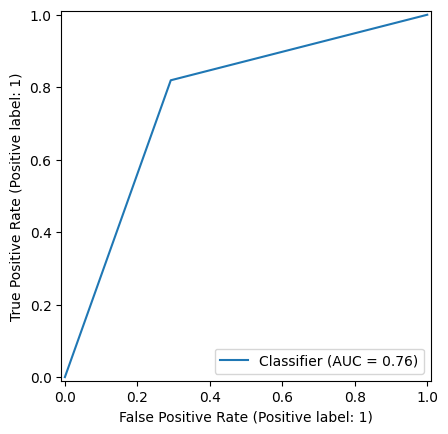

In [ ]:
RocCurveDisplay.from_predictions(y_holdout, predictions)

## Decision Tree v0.1.0
At this stage, we're attempting to predict pest type instead of pest presence.

### Brain Storm
1. remove records with `pest_value=0`
2. Convert pest_type to index values.
3. Build DT to predict `y = df_pests["pest_name"]`


In [ ]:
cols = ["pest_value", "season", "location_encoded", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests_with_pests[cols]

#initialize tree classifier and training parameters
clf_tree = tree.DecisionTreeClassifier(max_depth=11, random_state=42)
y = df_pests_with_pests["pest_name_encoded"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_tree.predict(X_holdout)
print(f"Accuracy is {accuracy_score(y_holdout, predictions)}")
print(f"Precision is {precision_score(y_holdout, predictions, average="weighted")}")
print(f"Recall is {recall_score(y_holdout, predictions, average="weighted")}")
print(f"F-measure is {f1_score(y_holdout, predictions, average="weighted")}")
df_pests_with_pests

Accuracy is 0.36914001862775536
Precision is 0.3442826356037169
Recall is 0.36914001862775536
F-measure is 0.35114450929314683


,year,std_week,pest_value,collect_type,max_temp,min_temp,humidity1,humidity2,rainfall,wind,sunshine,evp,pest_name,location,pest_name_encoded,location_encoded,has_pests,season,avg_temp
36,2003,37,2.9,Number/hill,28.9,25.2,95.7,86.6,101.7,4.6,1.0,1.9,Brownplanthopper,Cuttack,0,0,True,4,39.65
37,2003,38,9.7,Number/hill,31.7,25.8,91.4,77.3,50.2,3.9,6.8,3.8,Brownplanthopper,Cuttack,0,0,True,4,41.65
38,2003,39,19.4,Number/hill,32.9,26.5,91.1,74.0,19.2,3.0,7.5,4.0,Brownplanthopper,Cuttack,0,0,True,4,42.95
39,2003,40,9.0,Number/hill,32.3,25.7,88.3,72.9,9.8,2.4,6.7,3.7,Brownplanthopper,Cuttack,0,0,True,4,41.85
40,2003,41,6.0,Number/hill,32.7,25.9,90.0,71.6,2.7,2.1,7.7,3.8,Brownplanthopper,Cuttack,0,0,True,4,42.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19399,2011,48,31.0,Number/Light trap,30.2,17.2,78.1,41.6,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar,9,5,True,4,32.30
19400,2011,49,38.0,Number/Light trap,30.5,12.9,84.3,33.4,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar,9,5,True,1,28.15
19401,2011,50,6.0,Number/Light trap,30.2,14.2,83.4,49.6,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar,9,5,True,1,29.30
19402,2011,51,13.0,Number/Light trap,29.0,11.8,81.9,49.3,0.0,0.0,0.0,0.0,Yellowstemborer,Rajendranagar,9,5,True,1,26.30


# Random Forest - Lydia

In [4]:
df = pd.read_csv('RICE.csv', encoding="utf-8")
# Select only numeric columns
num_df = df.select_dtypes(include=[np.number]).copy()

corr = num_df.corr()
corr

,year,std_week,pest_value,max_temp,min_temp,humidity1,humidity2,rainfall,wind,sunshine,evp
year,1.000000,-0.000039,0.023143,0.015218,0.062260,0.077025,0.062972,-0.031034,-0.201246,-0.068448,-0.164007
std_week,-0.000039,1.000000,0.026777,-0.151632,0.052939,0.154681,0.257279,0.150812,-0.056174,-0.158878,-0.076323
pest_value,0.023143,0.026777,1.000000,0.010841,0.052029,0.066901,0.082626,-0.015998,-0.047848,-0.012022,0.026391
max_temp,0.015218,-0.151632,0.010841,1.000000,0.657952,-0.270353,-0.318608,-0.102012,0.126780,0.160298,0.223654
min_temp,0.062260,0.052939,0.052029,0.657952,1.000000,0.051965,0.323908,0.221505,0.273330,-0.134484,0.173550
humidity1,0.077025,0.154681,0.066901,-0.270353,0.051965,1.000000,0.621996,0.155136,-0.234460,-0.211710,-0.095929
humidity2,0.062972,0.257279,0.082626,-0.318608,0.323908,0.621996,1.000000,0.401561,0.032512,-0.380794,-0.020470
rainfall,-0.031034,0.150812,-0.015998,-0.102012,0.221505,0.155136,0.401561,1.000000,0.100092,-0.273260,0.005753
wind,-0.201246,-0.056174,-0.047848,0.126780,0.273330,-0.234460,0.032512,0.100092,1.000000,-0.114133,0.076622
sunshine,-0.068448,-0.158878,-0.012022,0.160298,-0.134484,-0.211710,-0.380794,-0.273260,-0.114133,1.000000,0.041709


In [5]:
corr_with_target = num_df.corr()["pest_value"].sort_values(ascending=False)
print(corr_with_target)

pest_value    1.000000
humidity2     0.082626
humidity1     0.066901
min_temp      0.052029
std_week      0.026777
evp           0.026391
year          0.023143
max_temp      0.010841
sunshine     -0.012022
rainfall     -0.015998
wind         -0.047848
Name: pest_value, dtype: float64


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = df.sort_values(by=["location", "pest_name", "year", "std_week"])


# ---- ENCODE CATEGORICAL COLUMNS ----
label_cols = ["collect_type", "pest_name", "location"]
encoders = {}

for col in label_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

# ---- SELECT FEATURES & TARGET ----
X = df.drop(["pest_value"], axis=1)
y = df["pest_value"]

df = df.sort_values(by=["year", "std_week"])
df["PestValue_Lag1"] = df["pest_value"].shift(1)
df["PestValue_Lag2"] = df["pest_value"].shift(2)
df = df.dropna()  # remove first rows with NaN

# ---- TRAIN/TEST SPLIT ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---- RANDOM FOREST MODEL ----
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42
)

model.fit(X_train, y_train)

# ---- PREDICTIONS ----
y_pred = model.predict(X_test)

# ---- EVALUATION ----
print("RMSE:", mean_squared_error(y_test, y_pred) ** 0.5)
print("R² Score:", r2_score(y_test, y_pred))

# ---- FEATURE IMPORTANCE ----
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print(importances)


RMSE: 3008.086310456538
R² Score: 0.25942273137268257
         Feature  Importance
1       std_week    0.215717
11     pest_name    0.168061
6      humidity2    0.158234
7       rainfall    0.112514
3       max_temp    0.107307
4       min_temp    0.070046
9       sunshine    0.040881
10           evp    0.037531
5      humidity1    0.034455
12      location    0.029630
0           year    0.014854
8           wind    0.010432
2   collect_type    0.000337


In [7]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [8]:
df = pd.read_csv("RICE.csv")

# Encode only Location & Collection Type (not pest name!)
enc = LabelEncoder()
df["collect_type"] = enc.fit_transform(df["collect_type"])
df["location"] = enc.fit_transform(df["location"])


In [9]:
pest_list = df["pest_name"].unique()
pest_list

array(['Brownplanthopper', 'Gallmidge', 'Greenleafhopper', 'LeafFolder',
       'Yellowstemborer', 'Caseworm', 'Miridbug',
       'Whitebackedplanthopper', 'ZigZagleafhopper', 'LeafBlast',
       'NeckBlast'], dtype=object)


===== OVERALL PERFORMANCE =====
Accuracy : 0.433
Precision: 0.526
Recall   : 0.433
F1 Score : 0.449

Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.25      0.28       392
           1       0.23      0.75      0.35       187
           2       0.69      0.38      0.49       603
           3       0.36      0.15      0.21       457
           4       0.95      0.89      0.92       418
           5       0.26      0.25      0.26       343
           6       0.31      0.29      0.30       229
           7       0.31      0.49      0.38        41
           8       0.12      0.19      0.15       250
           9       0.78      0.54      0.64       867
          10       0.18      0.82      0.30        94

    accuracy                           0.43      3881
   macro avg       0.41      0.46      0.39      3881
weighted avg       0.53      0.43      0.45      3881


Confusion Matrix:
 [[ 98  42  33  27   0  14  30   0  58  21

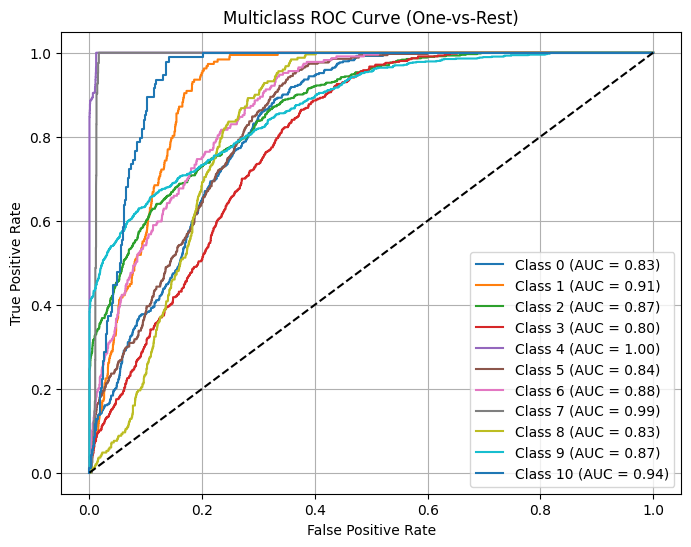


Top Feature Importances:

           Feature  Importance
0             year    0.242083
2     collect_type    0.180677
11        location    0.102372
12  PestValue_Lag1    0.083049
13  PestValue_Lag2    0.082991
5        humidity1    0.042691
4         min_temp    0.037466
10             evp    0.037414
3         max_temp    0.034469
8             wind    0.034063
6        humidity2    0.033215
1         std_week    0.030337
9         sunshine    0.023983
14           month    0.017040
7         rainfall    0.013983


In [10]:
# ============================================================
# 1. IMPORT LIBRARIES
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report,
    roc_curve, auc
)

# ============================================================
# 2. LOAD DATA
# ============================================================

df = pd.read_csv('RICE.csv', encoding="utf-8")

# ============================================================
# 3. ENCODE CATEGORICAL FEATURES
# ============================================================

label_cols = ["collect_type", "location", "pest_name"]
encoders = {}

for col in label_cols:
    enc = LabelEncoder()
    df[col] = enc.fit_transform(df[col])
    encoders[col] = enc

# ============================================================
# 4. FEATURE ENGINEERING
# ============================================================

# ---- Lag features (temporal dependency)
df["PestValue_Lag1"] = df.groupby("pest_name")["pest_value"].shift(1)
df["PestValue_Lag2"] = df.groupby("pest_name")["pest_value"].shift(2)
df.fillna(0, inplace=True)

# ---- Seasonality
df["month"] = df["std_week"] // 4 + 1
df["season"] = df["month"].apply(
    lambda m: "Kharif" if m in [6, 7, 8, 9, 10] else "Rabi"
)
df["season"] = LabelEncoder().fit_transform(df["season"])

# ============================================================
# 5. DEFINE FEATURES & TARGET
# ============================================================

X = df.drop(["pest_name", "pest_value"], axis=1)
y = df["pest_name"]

# ============================================================
# 6. TRAIN / TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# ============================================================
# 7. TRAIN RANDOM FOREST CLASSIFIER
# ============================================================

clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    random_state=42,
    class_weight="balanced"
)

clf.fit(X_train, y_train)

# ============================================================
# 8. PREDICTIONS
# ============================================================

y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

# ============================================================
# 9. STANDARD PERFORMANCE METRICS
# ============================================================

print("\n===== OVERALL PERFORMANCE =====")
print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted'):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred, average='weighted'):.3f}")
print(f"F1 Score : {f1_score(y_test, y_pred, average='weighted'):.3f}")

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# ============================================================
# 10. CONFUSION MATRIX + TP / FP / TN / FN
# ============================================================

cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y)

print("\nConfusion Matrix:\n", cm)

for i, cls in enumerate(classes):
    TP = cm[i, i]
    FP = cm[:, i].sum() - TP
    FN = cm[i, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    print(f"\nClass {cls}:")
    print(f"  TP={TP}, FP={FP}, TN={TN}, FN={FN}")
    print(f"  TPR (Recall) = {TPR:.3f}")
    print(f"  FPR          = {FPR:.3f}")

# ============================================================
# 11. MULTICLASS ROC CURVE (ONE-vs-REST)
# ============================================================

# Binarize true labels
y_test_bin = label_binarize(y_test, classes=classes)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

for i in range(len(classes)):
    plt.plot(
        fpr[i], tpr[i],
        label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve (One-vs-Rest)")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# 12. FEATURE IMPORTANCE
# ============================================================

importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nTop Feature Importances:\n")
print(importances.head(15))


# Random Forest - Tanmay

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cols = ["humidity2", "min_temp", "humidity1"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = RandomForestClassifier(max_depth=5, random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [ ]:
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7179663345929234
Precision is 0.7170723582003761
Recall is 0.8096980786825252
F-measure is 0.7638089758342923
TPR-FPR is 2.0226544342727517


In [ ]:
cols = ["year", "season", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests[cols]

#initialize tree classifier and training parameters
clf_tree = RandomForestClassifier(max_depth=11, criterion="entropy", random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

#fit the model to the training data
clf_tree.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, random_state=42)

In [ ]:
predictions = clf_tree.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.788388869804191
Precision is 0.7886648682016557
Recall is 0.8572735590118938
F-measure is 0.8202509483513277
TPR-FPR is 2.8534642154021546


# Gradient Boost - Tanmay

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

cols = ["year", "season", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests[cols]

# Initialize classifier and training parameters
clf_gb = GradientBoostingClassifier(learning_rate=0.05,
    max_depth=11, random_state=42)
y = df_pests["has_pests"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

# Fit the model to the training data
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=11, random_state=42)

In [ ]:
# Predict on unseen data
predictions = clf_gb.predict(X_holdout)
print_performance_measures(y_holdout, predictions)

Accuracy is 0.7694950188938509
Precision is 0.7687309074625195
Recall is 0.825556572125648
F-measure is 0.8013617525162818
TPR-FPR is 2.7264809907993808


In [ ]:
cols = ["year", "season", "humidity1", "humidity2", "max_temp", "min_temp", "rainfall", "wind", "sunshine", "evp"]
df_relevant_features = df_pests[cols]

# Initialize classifier and training parameters
clf_gb = GradientBoostingClassifier(learning_rate=0.05,
    max_depth=11, random_state=42)
y = df_pests["pest_name_encoded"]
X_train, X_holdout, y_train, y_holdout = train_test_split(df_relevant_features.values, y, test_size=0.3,
random_state=42)

# Fit the model to the training data
clf_gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=11, random_state=42)

In [ ]:
predictions = clf_gb.predict(X_holdout)

# Redefine print_performance_measures with the corrected average parameter for multiclass classification
def print_performance_measures(y_true, y_pred):
  print(f"Accuracy is {accuracy_score(y_true, y_pred)}")
  print(f'Precision is {precision_score(y_true, y_pred, average="weighted")}')
  print(f"Recall is {recall_score(y_true, y_pred, average="weighted")}") # Changed line
  print(f"F-measure is {f1_score(y_true, y_pred, average="weighted")}") # Changed line
  # print_tprfpr(y_true, y_pred) # Commented out as it's not directly applicable for multiclass

print_performance_measures(y_holdout, predictions)

Accuracy is 0.2030230161456544
Precision is 0.2201198574806025
Recall is 0.2030230161456544
F-measure is 0.20891634002704584
